# SVM Example

Here we

In [1]:
%matplotlib notebook
%matplotlib inline


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets.samples_generator import make_blobs

import torchbearer
import torchbearer.callbacks as callbacks
from torchbearer import Trial
from torchbearer.callbacks import L2WeightDecay, ExponentialLR


# Model

/home/matt/miniconda3/envs/jupyter/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: list.remove(x): x not in list

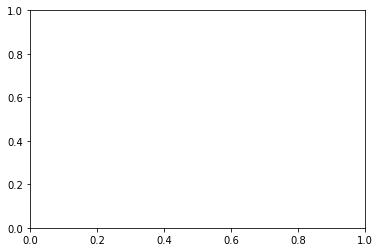

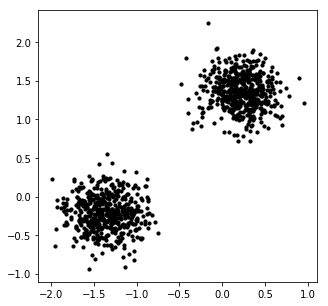

In [3]:
class LinearSVM(nn.Module):
    """Support Vector Machine"""

    def __init__(self):
        super(LinearSVM, self).__init__()
        self.w = nn.Parameter(torch.randn(1, 2), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        h = x.matmul(self.w.t()) + self.b
        return h


def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1 - y_pred.t() * y_true, min=0))


X, Y = make_blobs(n_samples=1024, centers=2, cluster_std=1.2, random_state=1)
X = (X - X.mean()) / X.std()
Y[np.where(Y == 0)] = -1
X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)


delta = 0.01
x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
x, y = np.meshgrid(x, y)
xy = list(map(np.ravel, [x, y]))

CONTOUR = torchbearer.state_key('contour')

def mypause(interval):
    backend = plt.rcParams['backend']
    if backend in matplotlib.rcsetup.interactive_bk:
        figManager = matplotlib._pylab_helpers.Gcf.get_active()
        if figManager is not None:
            canvas = figManager.canvas
            if canvas.figure.stale:
                canvas.draw_idle()
            canvas.start_event_loop(interval)
            return


@callbacks.on_start
def scatter(_):
    plt.figure(figsize=(5, 5))
    plt.ion()
    plt.scatter(x=X[:, 0], y=X[:, 1], c="black", s=10)


@callbacks.on_step_training
def draw_margin(state):
    if state[torchbearer.BATCH] % 10 == 0:
        ax.clear()
        w = state[torchbearer.MODEL].w[0].detach().to('cpu').numpy()
        b = state[torchbearer.MODEL].b[0].detach().to('cpu').numpy()

        z = (w.dot(xy) + b).reshape(x.shape)
        z[np.where(z > 1.)] = 4
        z[np.where((z > 0.) & (z <= 1.))] = 3
        z[np.where((z > -1.) & (z <= 0.))] = 2
        z[np.where(z <= -1.)] = 1

        if CONTOUR in state:
            for coll in state[CONTOUR].collections:
                coll.remove()
            state[CONTOUR] = ax.contourf(x, y, z, cmap=plt.cm.jet, alpha=0.5)
        else:
            state[CONTOUR] = ax.contourf(x, y, z, cmap=plt.cm.jet, alpha=0.5)
            #plt.tight_layout()
            #plt.show()
            fig.canvas.draw()
        mypause(0.001)


svm = LinearSVM()
model = Trial(svm, optim.SGD(svm.parameters(), 0.1), hinge_loss, ['loss'],
              callbacks=[scatter, draw_margin, ExponentialLR(0.999, step_on_batch=True), L2WeightDecay(0.01, params=[svm.w])]).to('cuda')
model.with_train_data(X, Y, batch_size=32)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
model.run(epochs=50, verbose=1)

plt.ioff()
plt.show()
